In [1]:
from jaxstar import mistfit
from jaxstar.utils import *
from jax import random
import arviz, corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

In [11]:
ticid, teff_obs, feh_obs = 384984325, 5663, -0.09 # TOI-6109
teff_err, feh_err = 100, 0.1

## query TIC and Gaia info

In [3]:
tic = Catalogs.query_criteria(catalog="TIC", ID=ticid).to_pandas()

In [4]:
import astropy.units as u
from astropy.coordinates import SkyCoord
coord = SkyCoord(ra=tic.ra[0], dec=tic.dec[0], unit=(u.degree, u.degree), frame='icrs')

In [5]:
job = Gaia.cone_search(coord, radius=5*u.arcsec)

In [6]:
gaia = job.get_results().to_pandas()

In [7]:
gaia

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist
0,1636042515805110273,Gaia EDR3 241035596174886016,241035596174886016,1682237031,2016.0,50.131926,0.013905,42.606952,0.013043,6.733507,...,1.528513,6,5750.0,4.5,0.0,150.07156,-12.273368,59.076001,23.353074,0.000168


In [8]:
# parallax
parallax_obs = float(correct_gedr3_parallax_zeropoint(gaia))
parallax_err = float(correct_gedr3_parallax_error(gaia['parallax_error'], gaia['phot_g_mean_mag']))

/var/folders/68/h6r0kcq50914zzw8n_70l69c0000gn/T/ipykernel_57874/3928802602.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  parallax_obs = float(correct_gedr3_parallax_zeropoint(gaia))
/var/folders/68/h6r0kcq50914zzw8n_70l69c0000gn/T/ipykernel_57874/3928802602.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  parallax_err = float(correct_gedr3_parallax_error(gaia['parallax_error'], gaia['phot_g_mean_mag']))


In [9]:
# Kmag
tickeys = ['Kmag', 'e_Kmag', 'TWOMflag']
kmag, kmagerr, flag = np.array(tic[tickeys])[0].T
kmag, kmagerr, flag

(9.251, 0.022, 'AAA-222-111-000-0-0')

In [20]:
# correct extinction
ak, ak_err = extinction_mag_vector(float(gaia['l']), float(gaia['b']), 1e3/parallax_obs)

/var/folders/68/h6r0kcq50914zzw8n_70l69c0000gn/T/ipykernel_57874/3700743174.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ak, ak_err = extinction_mag_vector(float(gaia['l']), float(gaia['b']), 1e3/parallax_obs)


Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 28.222 s
  pix_info:   0.368 s
   samples:  15.336 s
      best:   3.002 s
       nan:   0.102 s
      sort:   9.339 s
       idx:   0.075 s
# bayestar2019 is used.


In [21]:
ak, ak_err

(array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]))

In [22]:
kmag_obs = kmag - ak[-1]
kmag_err = np.sqrt(kmagerr**2 + ak_err[-1]**2)

## fitting

In [23]:
mf = mistfit.MistFit()

In [24]:
mf.set_data(['kmag', 'teff', 'feh', 'parallax'],\
            [kmag_obs, teff_obs, feh_obs, parallax_obs],\
            [kmag_err, teff_err, feh_err, parallax_err])

In [25]:
# setup HMC
ns = 20000
mf.setup_hmc(num_warmup=ns, num_samples=ns)

In [26]:
# run
rng_key = random.PRNGKey(0)
mf.run_hmc(rng_key, linear_age=True, flat_age_marginal=False, nodata=False)

sample: 100%|██████████| 40000/40000 [00:24<00:00, 1655.08it/s, 79 steps of size 1.93e-02. acc. prob=0.97] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       age      6.84      3.07      6.76      1.81     12.06   1123.77      1.00
  distance      0.15      0.00      0.15      0.15      0.15   7627.78      1.00
       eep    365.34     24.42    367.52    334.43    404.60   1087.75      1.00
  feh_init     -0.04      0.08     -0.04     -0.16      0.09   4332.15      1.00

Number of divergences: 0


In [27]:
mcmc = mf.mcmc
samples = mf.samples

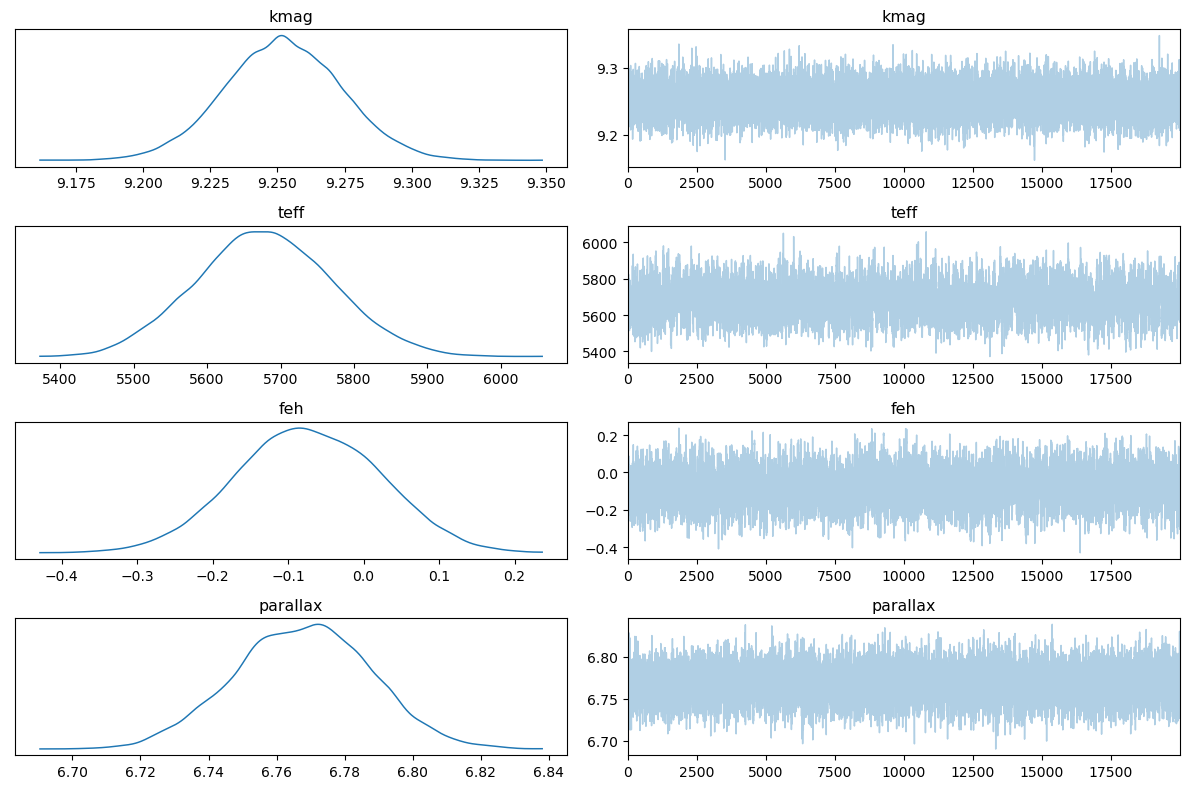

In [28]:
# trace plot
fig = arviz.plot_trace(mcmc, var_names=mf.obskeys)
plt.tight_layout()

In [29]:
# keys and observed values for corner plot
outkeys = mf.obskeys + ['mass', 'radius', 'age', 'eep']
obsvals = mf.obsvals + [None] * 4

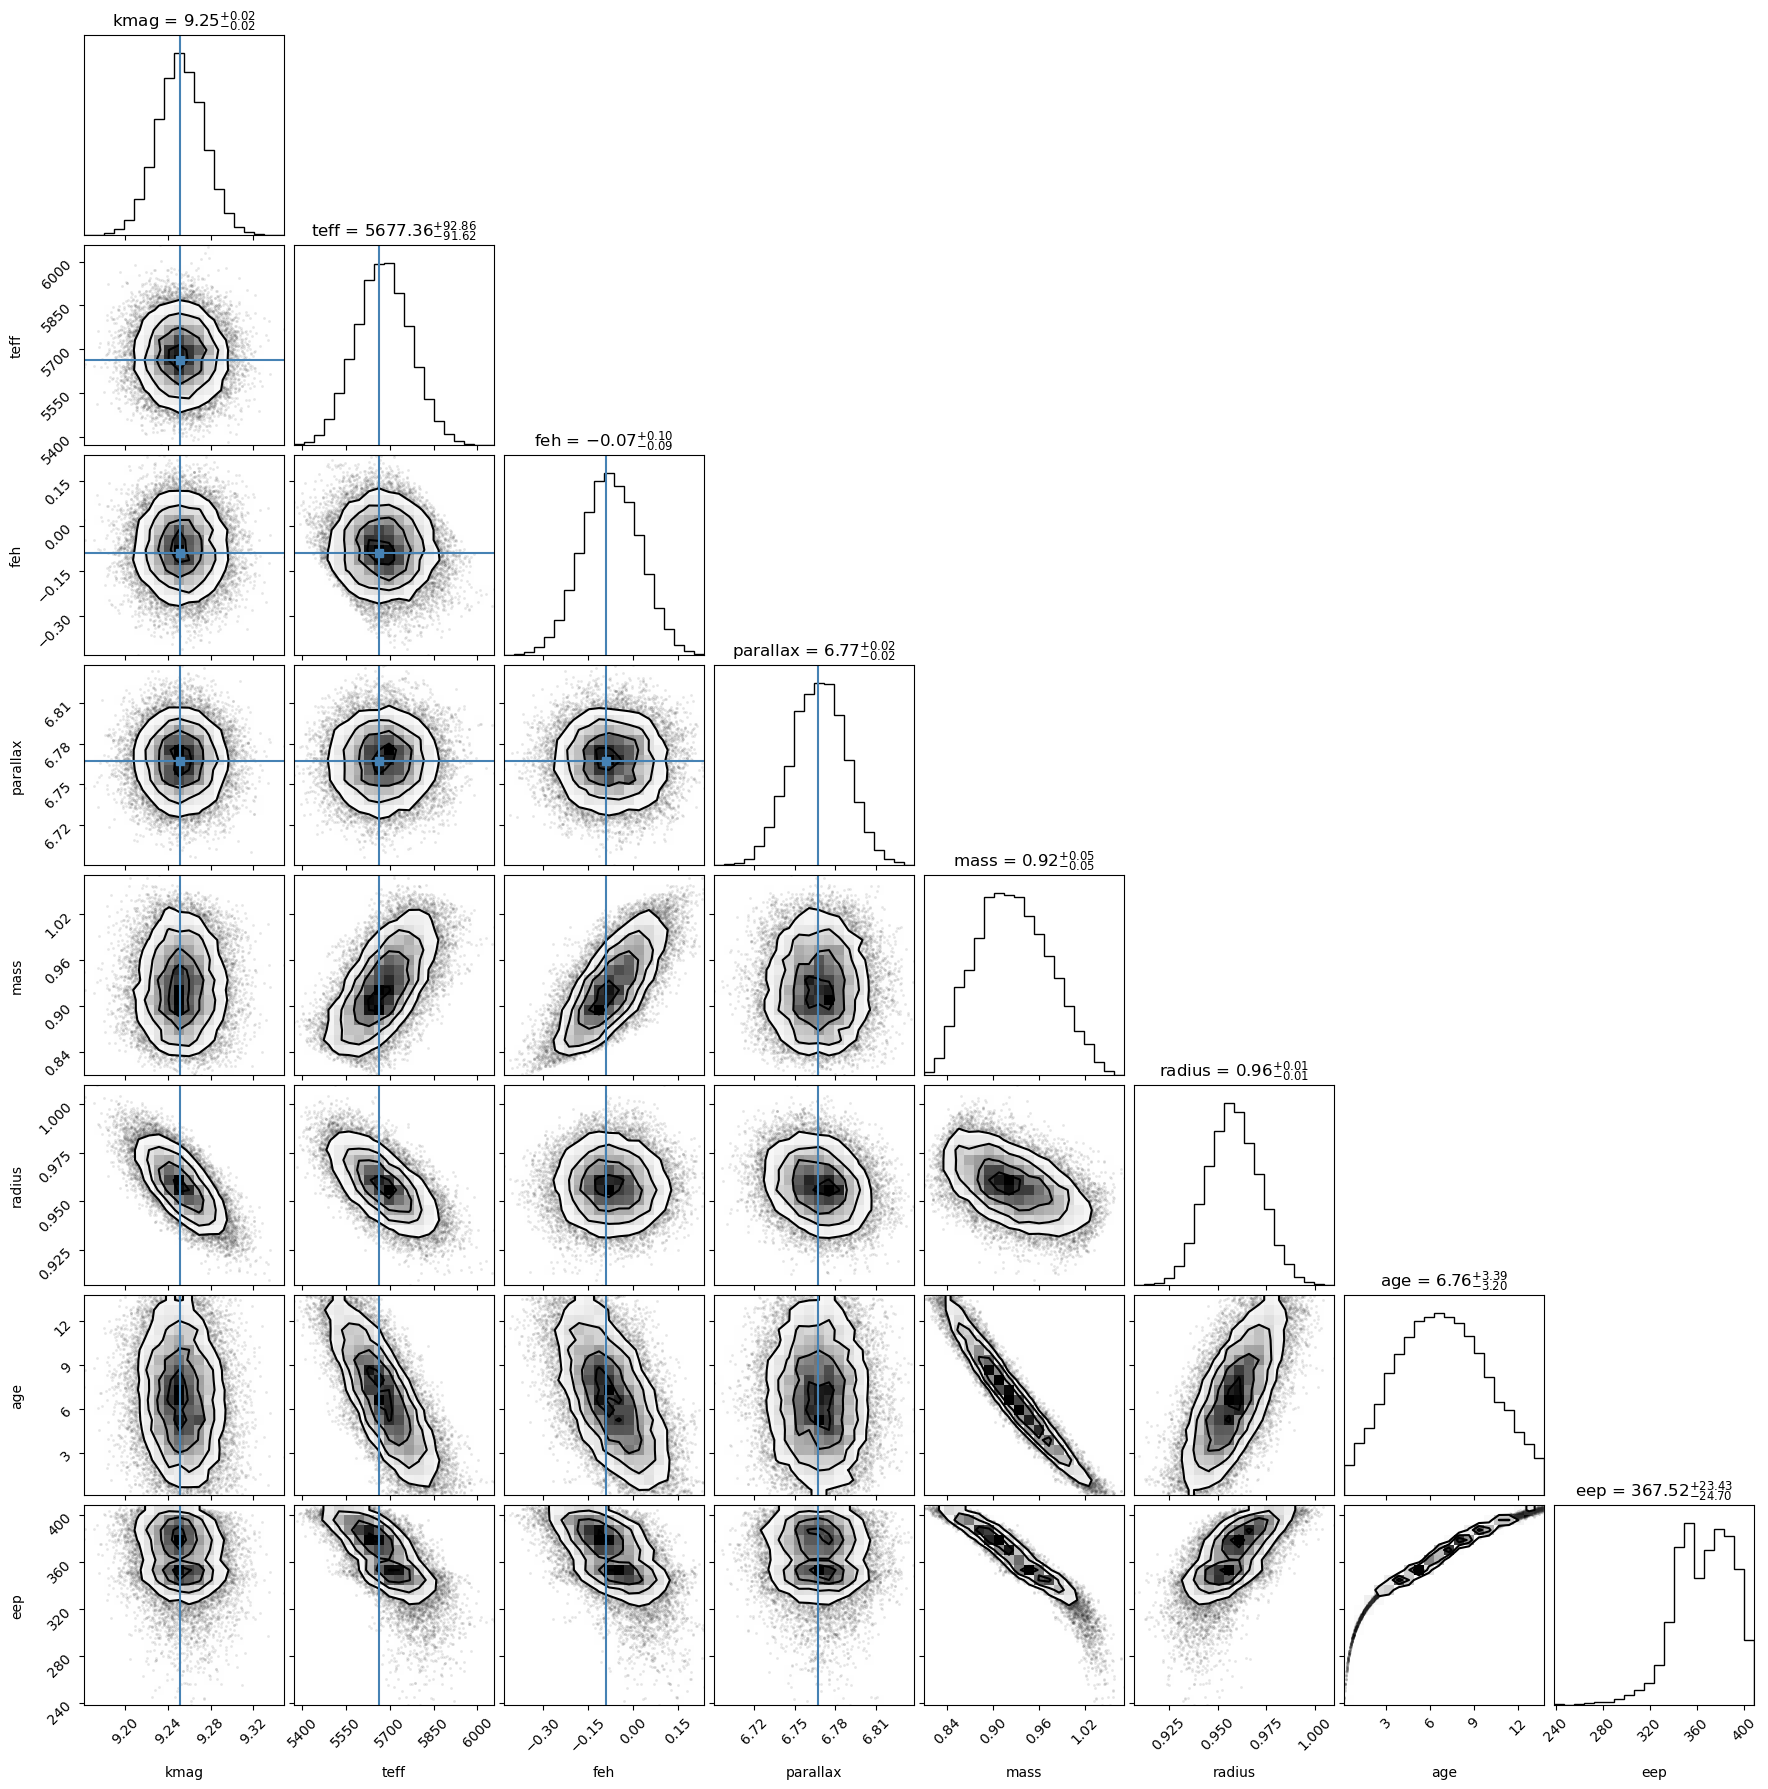

In [32]:
params = np.array(pd.DataFrame(data=dict(zip(outkeys, [samples[k] for k in outkeys]))))
fig = corner.corner(params, show_titles="%.2f", truths=obsvals, labels=outkeys)
plt.savefig("%s_corner.png"%ticid, dpi=200, bbox_inches="tight")

In [33]:
params_out = pd.DataFrame(data=dict(zip(outkeys+['logg'], [samples[k] for k in outkeys+['logg']])))

In [34]:
params_out

,kmag,teff,feh,parallax,mass,radius,age,eep,logg
0,9.273417,5817.859375,0.043636,6.770225,1.028024,0.933220,0.403239,277.703674,4.510158
1,9.269703,5817.986328,0.038625,6.767713,1.025600,0.935215,0.569679,288.648102,4.507273
2,9.288306,5801.143555,0.035557,6.768059,1.019321,0.928818,0.589881,289.183533,4.510614
3,9.270096,5806.353027,0.064178,6.762282,1.032364,0.936570,0.401844,277.571533,4.508885
4,9.278675,5798.863770,0.062542,6.762342,1.029487,0.933629,0.406923,277.735382,4.510438
...,...,...,...,...,...,...,...,...,...
19995,9.209499,5645.630859,0.046241,6.747372,0.959362,0.981325,6.072967,363.619781,4.436394
19996,9.286053,5560.396973,0.047664,6.747324,0.932004,0.955435,7.041201,367.251740,4.446978
19997,9.255377,5593.436035,-0.006455,6.746210,0.919969,0.966574,7.898830,376.361481,4.431273
19998,9.261721,5660.324707,-0.019803,6.775641,0.941597,0.953419,5.767591,356.248810,4.453353


In [35]:
params_out.to_csv("%s_samples.csv"%ticid, index=False)